### 統計學習與深度學習
### Homework 2


請將IPYNB檔與IPYNB Export之HTML檔上傳至COOL作業區。回答作業時建議使用 "三明治" 答題法。也就是說，先說明要做什麼，然後列出程式碼與結果，最後說明這些結果的意義。作業自己做。嚴禁抄襲。不接受紙本繳交，不接受遲交。請以英文或中文作答。


### 第一題 [Data Preprocessing]

(10%) 資料前處理是一個重要的工作，本題將利用UCI的"Adult" dataset <https://archive.ics.uci.edu/ml/datasets/Adult>來練習資料前處理。我們使用這個資料集的方式是用來建構預測最後一個收入欄位是'>50K'或'<=50K'。這個資料集已經先切好了Training跟Test。我們將會沿用這個切割。

資料前處理包含以下工作:
* 生成以下numpy變數: x_train(訓練特徵)、y_train(訓練標籤)、x_test(測試特徵)、y_test(測試標籤)。用一個Dictionary組織將這些變數，其中Key為變數名稱，Value為之前生成的變數內容。
* 最後一欄為標籤，將'>50K'與'<=50K'轉成1跟0。其他欄位為特徵。
* 把所有含有缺值的Rows刪除。
* 所有數值欄位標準化(均數為0，變異數為1)。測試資料特徵需用訓練資料的均數與變異數標準化。
* 所有類別欄位(如native-country與workclass)都應使用"1-of-K"轉換成0與1的欄位。
* 我們只考慮在訓練資料中出現超過(含)10次的特徵值。如果一個特徵值出現不到10次，則刪除這個特徵值所對應的1-of-K欄位。
* 你可以使用sklearn中的工具函數進行1-of-K encoding與變數標準化。


前處理完成後，比較你生成的Dictionary與由**adult_m50k.pickle**讀入的資料比較，確定內容相同。

讀取**adult_m50k.pickle**的方式如下:

In [4]:
import pickle
dsfile = 'adult_m50k.pickle'
with open(dsfile, 'rb') as fh1:
    adult50kp = pickle.load(fh1)

這個adult50kp是個Dictionary，裡面有:

In [5]:
adult50kp.keys()

dict_keys(['x_train', 'y_train', 'x_test', 'y_test', 'columnname', 'num_col'])

其中'x_train', 'y_train', 'x_test', 'y_test'分別是訓練資料特徵、訓練資料標記、測試資料特徵、測試資料標記。'num_col'是連續變數特徵的欄位名稱。

In [6]:
adult50kp['num_col']

['capital-loss',
 'hours-per-week',
 'capital-gain',
 'educational-num',
 'age',
 'fnlwgt']

'columnname'是所有特徵資料的欄位名稱。

In [32]:
adult50kp['columnname']

array(['capital-loss', 'hours-per-week', 'capital-gain',
       'educational-num', 'age', 'fnlwgt', 'relationship_Husband',
       'relationship_Not-in-family', 'relationship_Other-relative',
       'relationship_Own-child', 'relationship_Unmarried',
       'relationship_Wife', 'race_Amer-Indian-Eskimo',
       'race_Asian-Pac-Islander', 'race_Black', 'race_Other',
       'race_White', 'gender_Female', 'gender_Male',
       'occupation_Adm-clerical', 'occupation_Craft-repair',
       'occupation_Exec-managerial', 'occupation_Farming-fishing',
       'occupation_Handlers-cleaners', 'occupation_Machine-op-inspct',
       'occupation_Other-service', 'occupation_Priv-house-serv',
       'occupation_Prof-specialty', 'occupation_Protective-serv',
       'occupation_Sales', 'occupation_Tech-support',
       'occupation_Transport-moving', 'education_10th', 'education_11th',
       'education_12th', 'education_1st-4th', 'education_5th-6th',
       'education_7th-8th', 'education_9th', 'educatio

In [14]:
adult50kp['x_train'].shape

(30162, 102)





假設你生成的Dictionary叫adult50k，下面的範例程式比較這個變數與由picke檔案讀入的adult50kp中四個主要變數是否相同:

```python
elems = ['x_train', 'x_test', 'y_train', 'y_test']

for aelem in elems:
    cnomatch = np.sum(adult50kp[aelem] != adult50k[aelem])
    if cnomatch == 0:
        print(aelem, "match!")
    else:
        print(aelem, "%d elements no match!" % cnomatch)
```

為了讓大家更清楚欄位的安排，以下針對位在17與18欄(Index由0開始)的'gender_Female', 'gender_Male'操作。

In [33]:
colname = adult50kp['columnname']
colname[17:19]

array(['gender_Female', 'gender_Male'], dtype='<U41')

我們取出這兩欄來看看:

In [34]:
x_train = adult50kp['x_train']
x_train[:, 17:19]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]])

這兩欄應該只有其中一個是1，另一個是0。因此By Rows加總會是1:

In [35]:
x_train[:, 17:19].sum(axis = 1)

array([1., 1., 1., ..., 1., 1., 1.])

### 第二題 [ROC and AUC]
(35%) Receiver operation characteristic (ROC)曲線以及其線下面積 (Area Under Curve; AUC)為衡量分類器預測能力常用的工具。本題將練習繪製ROC以及計算AUC。
在這之前我們必須載入資料，訓練模型，並進行預測:

In [21]:
import pickle
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# load dataset
dsfile = 'adult_m50k.pickle'
with open(dsfile, 'rb') as fh1:
    adult50kp = pickle.load(fh1)
    
#train prediction model    
c = 0.3
lr2 = LogisticRegression(solver = 'lbfgs', C= c, max_iter = 1000)
lr2.fit(adult50kp['x_train'], adult50kp['y_train'])
#make prediction
ypred = lr2.predict(adult50kp['x_test'])
ypredprob = lr2.predict_proba(adult50kp['x_test'])
#compute accuracy
ncorrect = np.sum(adult50kp['y_test'] == ypred)
accuracy_sk = ncorrect / adult50kp['y_test'].shape[0]
print("Accuracy = %f" % accuracy_sk)   
print(ypredprob.shape)
print(ncorrect)

Accuracy = 0.848406
(15060, 2)
12777


#### 回答下面問題:

* Q2.1 (17.5%): 基於`adult50kp['y_test']`與`ypredprob`繪製ROC Curve。
* Q2.2 (17.5%): 計算繪製出的ROC Curve的AUC。

規定與提示:
* 禁用現成的ROC與AUC計算函數，如 `sklearn.metrics.roc_curve`與`sklearn.metrics.auc`。違者本題零分。
* 計算AUC時可以利用相鄰的FP_Rate與其對應的TP_Rate所形成的梯形近似該小塊面積，然後加總所有梯形的面積即可得到AUC。梯形面積計算請參考下圖。

![AUC Tip](tipsauc.png)

### 第三題 [Logistic Regression with L2 Regularization]

(55%) The Logistic regression with L2 regularization minimize the following error function:


$\frac{\lambda}{2} w^T w - \sum_{i=1}^n [ t_i \ln y_i  + (1 - t_i) \ln (1 - y_i)],$

where $y_i = \frac{1}{1 + exp({-w^T x_i})}$ and $t_i \in \{0, 1\}$ is the label value, $x_i$ is the feature vector, and $w$ is the regression coefficient vector. 


We are going to consider an extension of this model to allow different levels of regularization for different regression coefficients. Consider the constant term versus other features. The coefficient of the constant term is usually not regularized in logistic regression. It is because the constant term is related to the odds ratio when all features are zero, and regularizing this term will force the probability of the positive class given a zero feature vector to be 0.5, which may or may not be reasonable.  

Another consideration is regarding the continuous-valued features and binary-valued features. We typically normalize continuous-valued features to have zero means and unit variances but keep binary-value features untouched. It makes sense to have a single regularization value for the continuous-valued features since all of them have been normalized. Similarly, if we do not have additional information, then all binary-valued features can have the same level of regularization. However, using the same regularization coefficient for the continuous-valued and binary-valued features may not be reasonable. That is, it is often beneficial to have a regularization coefficient for the continuous-valued features and another regularization coefficient for the binary-valued features. 

The above discussion suggests that a more sophisticated way to regularize a logistic regression is to have three regularization coefficients: 0 for the constant, $a_1$ for continuous-valued features, and $a_2$ for the binary-valued features. It is possible to further refine the regularization coefficients. However, hyper-parameter tuning associated with more regularization coefficients may be costly. 

To achieve this goal, we are going to consider a variation of L2-regularized logistic regression that allows different levels of regularization for each coefficient. In the following discussion, we are going to use $X$ to denote the feature matrix in the training data. The i-th row in $X$, $x_i$, is the feature vector for the i-th training data. The last column of $X$ is one unless we do not include the constant term. 

In this model, each regression coefficient may be associated with a different regularization coefficient. Bearing with the risk of ambigulity, we (again) use the scalar $\lambda_k$ to denote the regularization coefficient for $w_k$.  The vector $w = [w_1, w_2, ..., w_D]^T$ is the  regression coefficient vector. Let $\Lambda$ denote the diagonal matrix that have $\lambda_k$ at $\Lambda_{kk}$. Our new error function becomes: 

$E(w) = \frac{1}{2} w^T \Lambda w - \sum_{i=1}^n [ t_i \ln y_i  + (1 - t_i) \ln (1 - y_i)],$

where $y_i = \frac{1}{1 + exp({-w^T x_i})}$. 

This model allows $w_k$ to have regularization coefficient $\lambda_k$. If the constant term is the last element in $w$, then setting $\lambda_D$ to $0$ allows us to free the constant term from regularization. We can set $\lambda_k$ associated with continuous-valued features to one value, and elements associated with binary-value features to another value. This will achieve our goal of a more refined regularization structure. 

Following the PRML textbook and the class discussion, we are going to train the model using the Newton-Raphson optimization method. In order to do so, you need to derive the gradient and hessian of $E(w)$. Given the training dataset, we can optimize $w$ via 

$w^{(new)} = w^{(old)} - H^{-1} \nabla E$

To do so, we need to have an initial vector of $w$ to kick start the iteration. One way to do this is to use the closed-form solution of ridge regression: $w = (X^T X + b I)^{-1} X^T t$, where $t$ is the vector of training labels. Set $b$ to the average of $\lambda_i$. Another way is to change the original L2 regularization term in ridge regression to $\frac{1}{2}w^T \Lambda w$ and derive the new closed-form solution that matches our model. 




Create a Python class named mylogistic_l2 that performs model training and prediction. 

The sample usage should be like the following:
```python
logic1 = mylogistic_l2(reg_vec = lambda_vec, max_iter = 1000, tol = 1e-5, add_intercept = True)
logic1.fit(X_train, Y_train)
ypred = logic1.predict(X_test)
```
The first line is to create an object with the specified regularization coefficient vector, lambda_vec, and set the maximum number of iteration to 1000. The "tol" parameter sets the stopping condition for Newton-Raphson optimization. The iteration will stop if the improvement on the error function is less than $10^{-5}$. The "add_intercept" option says that we need to add a column of ones to the end of X_train before model training. The length of lambda_vec, as a result, should match the number of columns after adding the "one column" when this option is turned on. 

Use the following skeleton to create your mylogistic_l2 class:
```python
class mylogistic_l2():
    def __init__(self, reg_vec, max_iter = 100, tol = 1e-5, add_intercept = True):
        """reg_vec: the regularization coefficient vector
           max_iter: maximum number of iteration to run for the Newton method
           tol: tolerance for the objective function
           add_intercept: whether to add intercept (a column of ones) at last column of the feature matrix"""
        ### Add your code here

    def fit(self, x, y, verbal = False):
        #Add your code here

    def predict(self, x):
        """doing prediction"""
        ### add your code here.     
```



To simplify the discussion, we use 0.5 as the threshold for the positive case when making predictions. That is, the output of the last line should be a numpy array of 0 and 1s.

#### Implementation Restrictions
You are allowed to use the "building block" libraries including numpy and scipy in your own mylogistic_l2 class. You will receive a zero score if you adopted an existing logistic regression classifier in your answer. The input features and labels for the training method should be numpy arrays. The input features and output labels for the predict method should be numpy arrays. 

#### Dataset
We are going to use to "Adult" dataset on the UCI machine learning reposition <https://archive.ics.uci.edu/ml/datasets/Adult>. Do not download the raw data from the website. Instead, load the processed data from **adult_m50k.pickle** using the following sample code: 

```python
dsfile = 'adult_m50k.pickle'
with open(dsfile, 'rb') as fh1:
    adult50kp = pickle.load(fh1)
```    
    
You can access the training and test data using the following keys: 'x_train', 'x_test', 'y_train', 'y_test'. In addition, the key 'columnname' map the a list of column names, and the key 'num_col' map to a list of numeric columns. 


Answer the following questions:

* Q3.1 (15%) Derive the gradient and hessian matrix for the new E(w). 
* Q3.2 (25%) Create your mylogistic_l2 class. Train your model and show the learned $w$ as well as test accuracy for the cases below. If $w$ is too long for you, show selected $w$ for continuous-valued, binary-valued, and the constant term.  
    * Case 1: lambda = 1 for all coefficients
    * Case 2: lambda = 1 for all but the intercept, no regularization for intercept term.
    * Case 3: lambda = 1 for numerical-valued features, lambda = 0.5 for binary-valued features, no regularization for intercept term.
* Q3.3 (10%) Further split the training data into subtraining (90%) and tuning (10%) to search for the best hyperparameters. Set the regularization coefficient for the constant term to zero. Allow different regularizations for continuous-valued and binary-valued features. Let $a_1$ and $a_2$ denote the regularization coefficients for continuous-valued and binary-valued features. Search the best $a_1$ and $a_2$ and report the test accuracy using the best hyper-parameters. You should follow the following procedure to search for the best hyperparameters. 
    1. Choose a set of grids among a reasonable range. For example, 10 grids in [0.01, 100]. 
    2. Conduct grid search with the constraint that $a_1 = a_2$. Record the best value $a_1^*$ and $a_2^*$.
    3. Fix $a_1 = a_1^*$, and search $a_2$ for the best value, call the result the new $a_2^*$. 
    4. Fix $a_2 = a_2^*$, and search $a_1$ for the best value.
    5. Report the selected $a_1$ and $a_2$.
    6. Train a model using the selected hyper-parameters, and report the test accuracy. 
  
* Q3.4 (5%) Use sklearn.linear_model.LogisticRegression to train and test the model (including hyperparameter tuning). Compare the estimated parameters and test accuracy with those from your own models. 

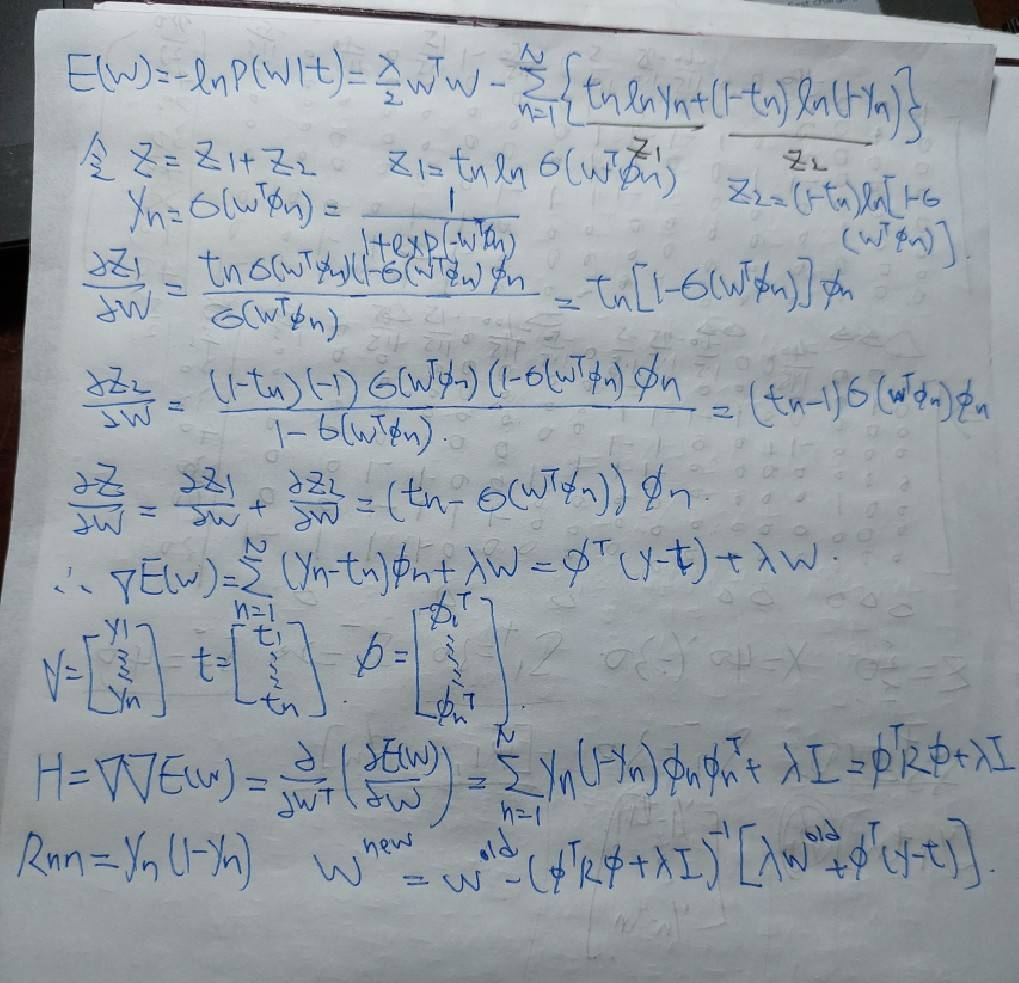

In [37]:
from IPython.core.display import Image, display
display(Image('https://i.imgur.com/qBFqW0K.jpg', width=700, unconfined=True))